In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import linmix
from linmix.linmix import LinMix
import math

In [31]:
# print([name for _, name, _ in pkgutil.iter_modules(['linmix'])])
help(linmix)
help(LinMix)

Help on package linmix:

NAME
    linmix - A hierarchical Bayesian approach to linear regression with error in both X and Y.

PACKAGE CONTENTS
    linmix

DATA
    __all__ = ['linmix']

FILE
    c:\users\iris reitsma\appdata\roaming\python\python38\site-packages\linmix-0.1.0.dev1-py3.8.egg\linmix\__init__.py


Help on class LinMix in module linmix.linmix:

class LinMix(builtins.object)
 |  LinMix(x, y, xsig=None, ysig=None, xycov=None, delta=None, K=3, nchains=4, parallelize=True, seed=None)
 |  
 |  A class to perform linear regression of `y` on `x` when there are measurement errors in
 |  both variables.  The regression assumes:
 |  
 |  eta = alpha + beta * xi + epsilon
 |  
 |  x = xi + xerr
 |  
 |  y = eta + yerr
 |  
 |  Here, `alpha` and `beta` are the regression coefficients, `epsilon` is the intrinsic random
 |  scatter about the regression, `xerr` is the measurement error in `x`, and `yerr` is the
 |  measurement error in `y`.  `epsilon` is assumed to be normally-distributed

In [32]:
# np.random.seed(2)

# def pxi(xi):
#     return np.exp(xi) * (1.0 + np.exp(2.75*xi))**(-1)
# fig = plt.figure()
# ax = fig.add_subplot(111)
# x = np.arange(-5,5, 0.01)
# ax.plot(x, pxi(x))
# ax.set_xlabel(r"$\xi$")
# ax.set_ylabel(r"$P(\xi)$")
# plt.show()

In [33]:
# def rejection_sample(p, pmax, prop, size):
#     out=[]
#     for s in range(size):
#         x = prop()
#         px = p(x)
#         pu = np.random.uniform(low=0.0, high=pmax)
#         while px < pu:
#             x = prop()
#             px = p(x)
#             pu = np.random.uniform(low=0.0, high=pmax)
#         out.append(x)
#     return np.array(out)
# pmax = 0.55 # max p(xi) determined by eye
# prop = lambda : np.random.uniform(low=-10, high=10) # truncating range to (-10, 10)
# xi = rejection_sample(pxi, pmax, prop, size=100)

In [34]:
# alpha = 1.0
# beta = 0.5
# sigsqr = 0.75**2
# epsilon = np.random.normal(loc=0, scale=np.sqrt(sigsqr), size=len(xi))
# eta = alpha + beta*xi + epsilon

# tau = np.std(xi)
# sigma = np.sqrt(sigsqr)
# t = 0.4 * tau
# s = 0.5 * sigma
# xsig = 5*t**2 / np.random.chisquare(5, size=len(xi))
# ysig =5*s**2 / np.random.chisquare(5, size=len(eta))


# x = np.random.normal(loc=xi, scale=xsig)
# y = np.random.normal(loc=eta, scale=ysig)
# print(len(xsig))
# print(len(x))

In [35]:
# lm = linmix.LinMix(x, y, xsig, ysig, K=2, seed=2)


In [36]:
# lm.run_mcmc(silent=False)

In [37]:
# Load in data
tbl = pd.read_csv('preprocessed_data_avg_30error.csv')
display(tbl.head())
# tbl = tbl[tbl['Filter']=='Ks'] # TODO


,Unnamed: 0,Source,Filter,Obs_number,Detected Name,Date obs,RA,DEC,Error_circle (arcsec),Position_source,...,log_L_NIR_errup_nodist,log_L_NIR_errlow_nodist,log_L_NIR_errup_noflux,log_L_NIR_errlow_noflux,log_L_X_errup_nodist,log_L_X_errlow_nodist,log_L_X_errup_noflux,log_L_X_errlow_noflux,log_L_NIR_upplim,log_L_X_upplim
0,0,RX_J1735.3-3540,J,3081,S,2014-05-07,17 35 23.75,-35 40 16.1,0.56,"Israel+2008, UVOT",...,0.003808,0.003808,0.184256,0.184256,0.108574,0.108574,0.184256,0.184256,NaN,NaN
1,2,RX_J1735.3-3540,H,3063,S,2014-05-07,17 35 23.75,-35 40 16.1,0.56,"Israel+2008, UVOT",...,0.002848,0.002848,0.184256,0.184256,0.108574,0.108574,0.184256,0.184256,NaN,NaN
2,4,RX_J1735.3-3540,Ks,3045,S,2014-05-07,17 35 23.75,-35 40 16.1,0.56,"Israel+2008, UVOT",...,0.003019,0.003019,0.184256,0.184256,0.108574,0.108574,0.184256,0.184256,NaN,NaN
3,6,UW_Crb,Ks,1081,S,2018-06-19,16 05 45.8746697208,25 51 45.246497976,0.10,"Gaia Collaboration 2020, Gaia",...,0.051416,0.051416,0.184256,0.184256,0.130288,0.130288,0.184256,0.184256,NaN,NaN
4,7,UW_Crb,H,1086,S,2018-06-19,16 05 45.8746697208,25 51 45.246497976,0.10,"Gaia Collaboration 2020, Gaia",...,0.038230,0.038230,0.184256,0.184256,0.130288,0.130288,0.184256,0.184256,NaN,NaN


C:\Users\Iris Reitsma\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


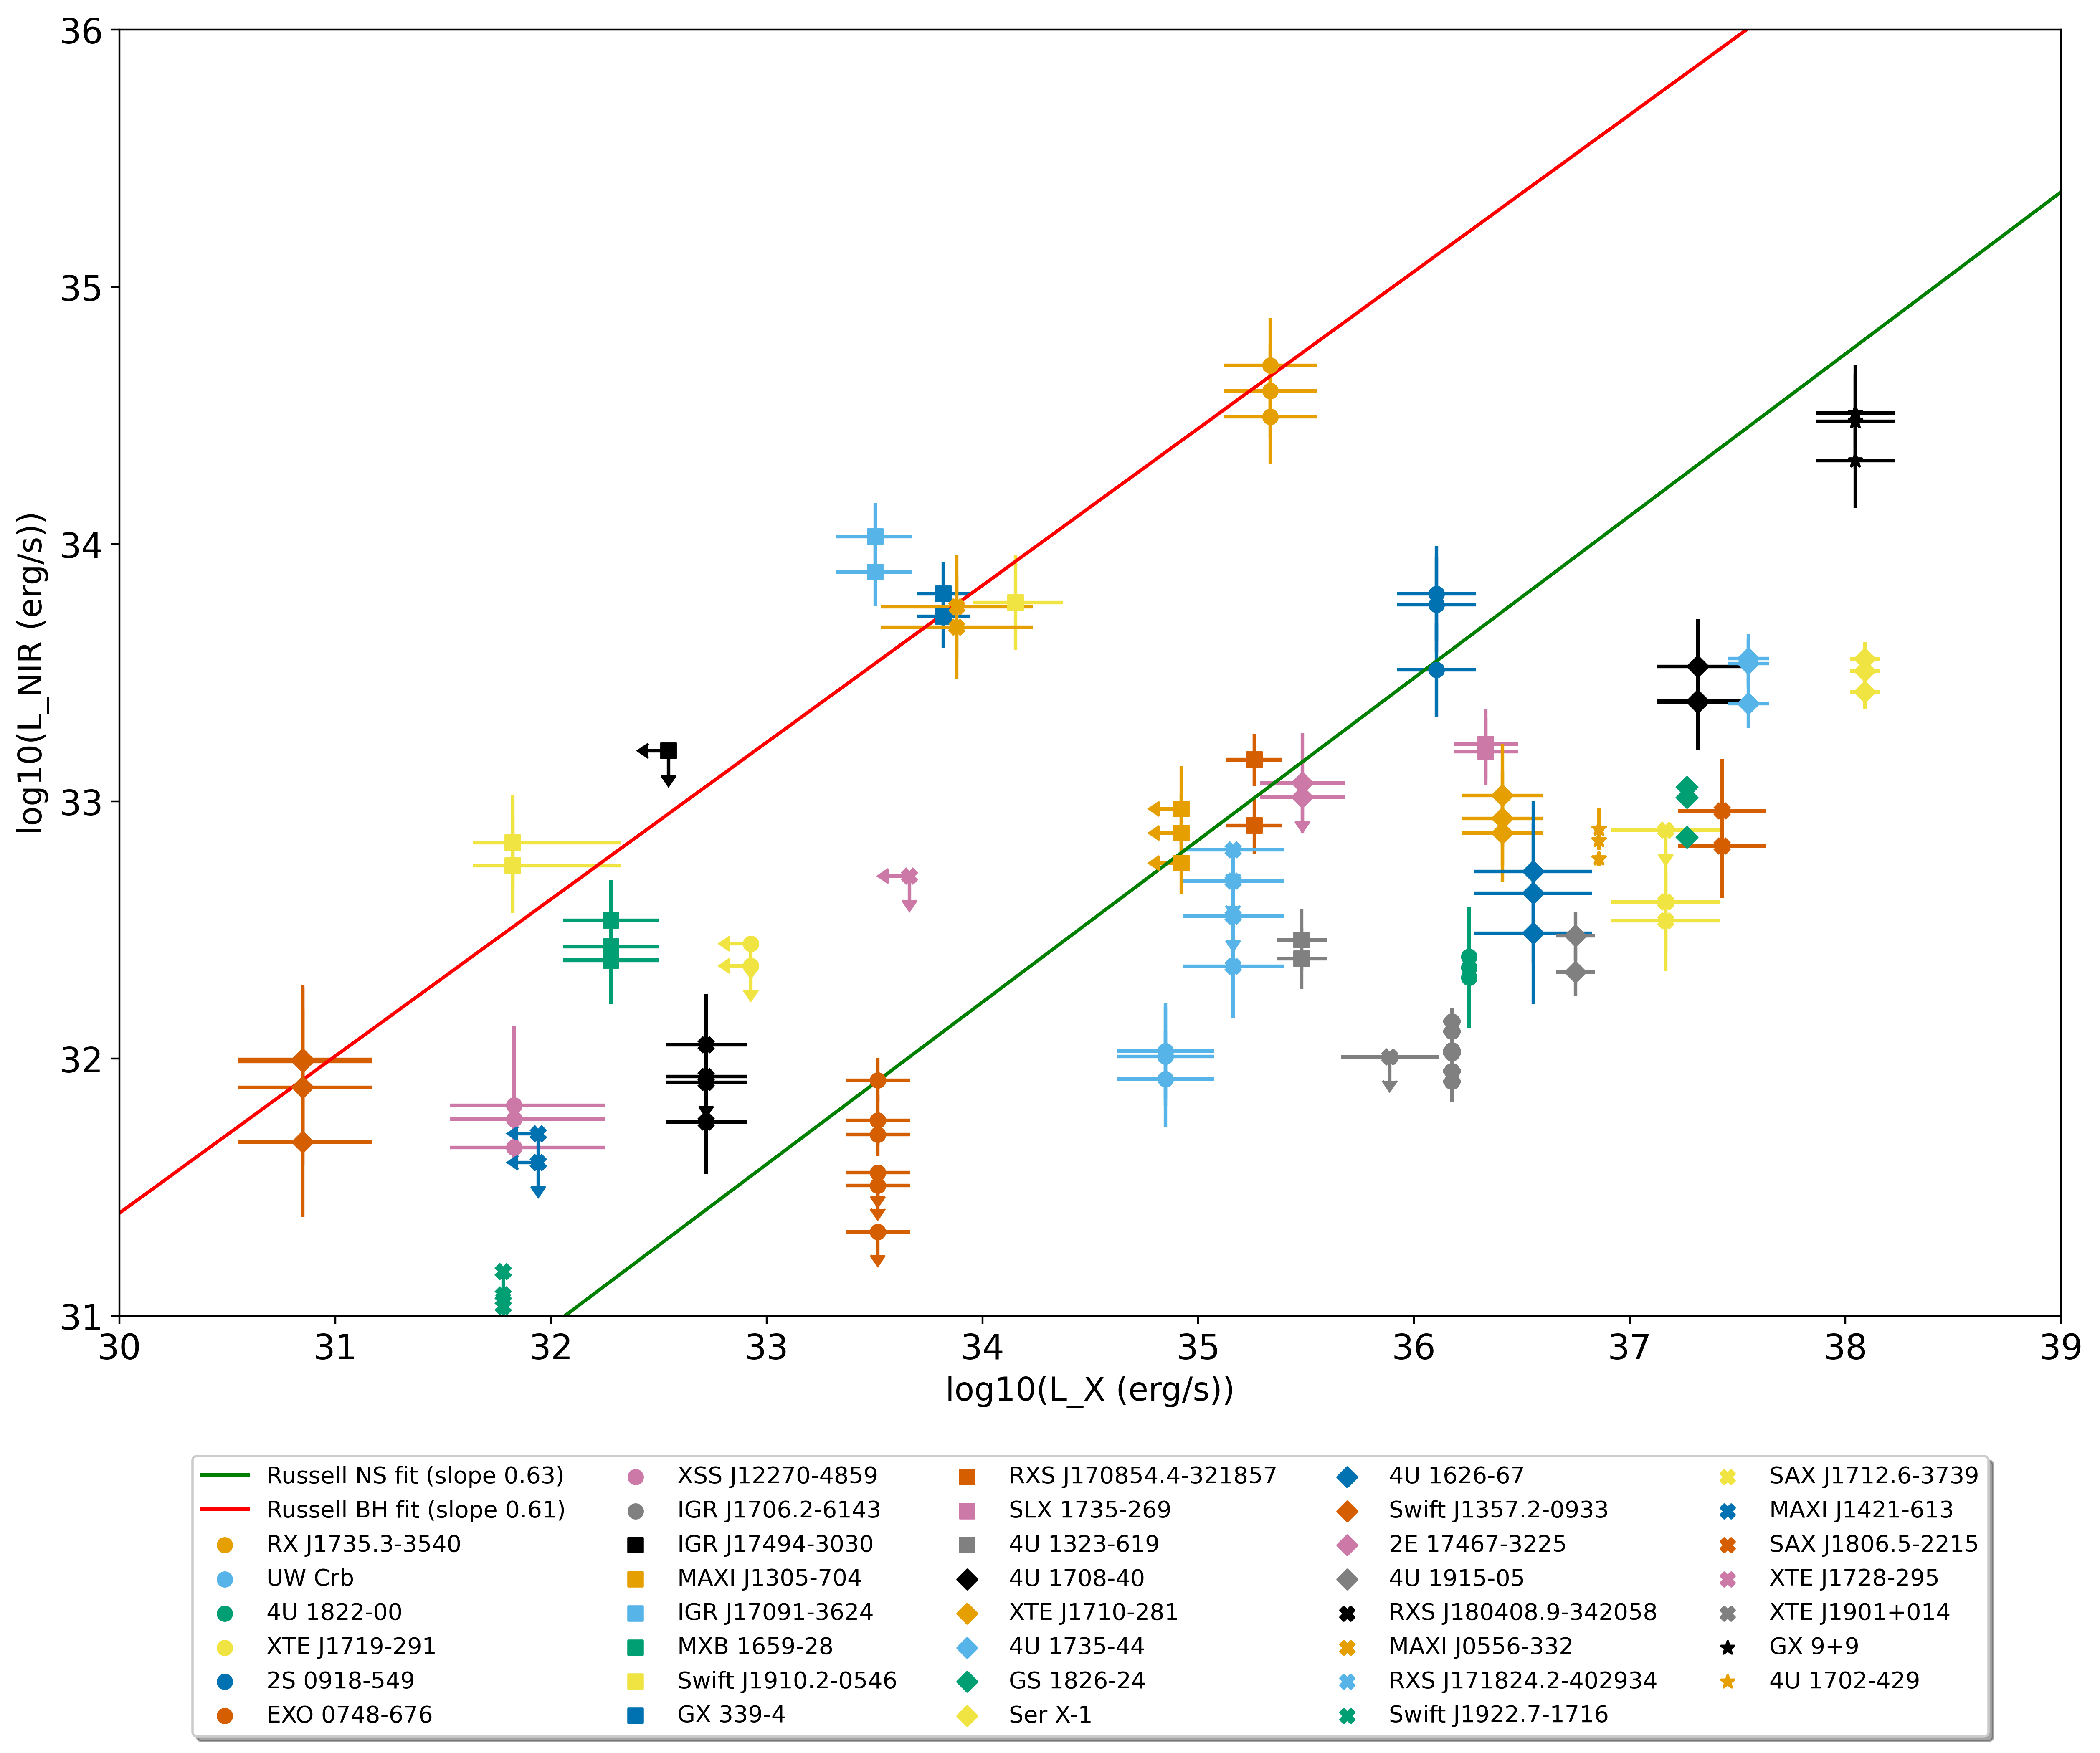

In [38]:
def plotfunc_scatter(ax, tbl, color, shape, label): 
    
    # Remove underscore from labels
    label = label.replace('_', ' ')
    # Plot regular data points 
    ax.scatter(tbl['log_L_X'], tbl['log_L_NIR'], label=label, c=color, marker=shape, zorder=10) 
    ax.errorbar(tbl['log_L_X'], tbl['log_L_NIR'], yerr=[[tbl['log_L_NIR_errlow']], [tbl['log_L_NIR_errup']]], xerr=[[tbl['log_L_X_errlow']], [tbl['log_L_X_errup']]], marker=shape, fmt='o', color=color)

    # Plot points with only upplim on NIR luminosity
    ax.scatter(tbl['log_L_X'], tbl['log_L_NIR_upplim'], label=label, c=color, marker=shape, zorder=10)      
    ax.errorbar(tbl['log_L_X'], tbl['log_L_NIR_upplim'], yerr=[tbl['log_L_NIR_upplim']*arrow_scale], xerr=[[tbl['log_L_X_errlow']], [tbl['log_L_X_errup']]], uplims = True, marker=shape, fmt='o', color=color)

    # Plot points with only upplim on X-ray luminosity
    ax.scatter(tbl['log_L_X_upplim'], tbl['log_L_NIR'], label=label, c=color, marker=shape, zorder=10)         
    ax.errorbar(tbl['log_L_X_upplim'], tbl['log_L_NIR'], yerr=[[tbl['log_L_NIR_errlow']], tbl[['log_L_NIR_errup']]], xerr=[tbl['log_L_X_upplim']*arrow_scale], xuplims = True, marker=shape, fmt='o', color=color)

    # Plot points with upplims on X-ray luminosity and NIR luminosity
    ax.scatter(tbl['log_L_X_upplim'], tbl['log_L_NIR_upplim'], label=label, c=color, marker=shape, zorder=10)         
    ax.errorbar(tbl['log_L_X_upplim'], tbl['log_L_NIR_upplim'], yerr=[tbl['log_L_NIR_upplim']*arrow_scale], xerr=[tbl['log_L_X_upplim']*arrow_scale], uplims=True, xuplims=True, marker=shape,fmt='o', color=color)





    
fig, ax = plt.subplots(figsize = (15, 10), dpi=400)
xrange= np.logspace(29, 41, num=10)
y = 10**10.8 * xrange**(0.63)
ax.plot(np.log10(xrange), np.log10(y), c='g', label='Russell NS fit (slope 0.63)')
y_bh = 10**13.1 * xrange**0.61
ax.plot(np.log10(xrange), np.log10(y_bh), c='r', label='Russell BH fit (slope 0.61)')
markers = ['o', 's', 'D', 'X', '*']
colors = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", 'grey']
options = np.array(np.meshgrid(markers, colors)).T.reshape(-1,2)
# print(options)

arrow_scale = 0.2 / np.log(10) / 30


i = 0
last_source = 'first'
for n, s in enumerate(tbl['Source']):

    # exclude not plotted sources from legend
    if np.isnan(tbl.iloc[n]['L_NIR']) and np.isnan(tbl.iloc[n]['L_NIR_upplim']) or np.isnan(tbl.iloc[n]['L_X']) and np.isnan(tbl.iloc[n]['L_X_upplim']):
        continue
        
    # every source gets a new shape-color combination
    if s != last_source: 
        i +=1
    shape = options[i][0]
    color = options[i][1]
    last_source = s
    
    # scatter plot the data for which luminosites are available
    try: 
        plotfunc_scatter(ax, tbl.iloc[n], color, shape, s)
    except:
        continue
        
ax.set_xlabel('log10(L_X (erg/s))', fontsize=14)
ax.set_ylabel('log10(L_NIR (erg/s))', fontsize=14)
ax.set_xlim(30, 39)
ax.set_ylim(31, 36)
ax.tick_params(axis='both', labelsize=15)

# remove duplicates from legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

ax.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True, shadow=True, ncol=5)
plt.show()

In [39]:


valid = ~(np.isnan(tbl['L_X']) | np.isnan(tbl['L_NIR']))

tbl['log_L_X_avgerr'] = (tbl['log_L_X_errlow'] + tbl['log_L_X_errup'])/2
tbl['log_L_NIR_avgerr'] = (tbl['log_L_NIR_errlow'] + tbl['log_L_NIR_errup'])/2

# x = list(tbl['log_L_X'][valid])
# y = list(tbl['log_L_NIR'][valid])
# xsig = list(tbl['log_L_X_avgerr'][valid])
# ysig = list(tbl['log_L_NIR_avgerr'][valid])

# for n, i in enumerate(xsig):
#     if math.isnan(i):
#         xsig[n] = 0.1 * x[n]
# for n, i in enumerate(ysig):
#     if math.isnan(i):
#         ysig[n] = 0.1 * y[n]
                

In [40]:
# lm = LinMix(x, y, xsig, ysig, K=2, seed=2)


In [12]:
# lm.run_mcmc(silent=False)

In [13]:
# fig = plt.figure(figsize=(10,4))
# ax = fig.add_subplot(121)
# # ax.scatter(xi, eta)
# ax.set_xlabel(r'$\xi$')
# ax.set_ylabel(r'$\eta$')
# ax.set_xlim(-6,6)
# ax.set_ylim(-3,4)
# ax = fig.add_subplot(122)
# ax.scatter(x, y, alpha=0.5)
# ax.errorbar(x, y, xerr=xsig, yerr=ysig, ls=' ', alpha=0.5)
# for i in range(0, len(lm.chain), 25):
#     xs = np.arange(30,41)
#     ys = lm.chain[i]['alpha'] + xs * lm.chain[i]['beta']
#     ax.plot(xs, ys, color='r', alpha=0.02)
# ys = alpha + xs * beta
# ax.plot(xs, ys, color='k')
# ax.set_xlabel(r'x')
# ax.set_ylabel(r'y')
# ax.set_xlim(30,40)
# ax.set_ylim(30,38)
# ax.plot([-6,6,6,-6,-6], [-3,-3,4,4,-3], color='k')
# fig.tight_layout()

In [14]:
# plt.scatter(lm.chain['beta'], lm.chain['alpha'], s=0.1)
# plt.xlabel('slope')
# plt.ylabel('offset')
# plt.show()

In [41]:
# remove 2 outliers
outliers = ['RX_J1735.3-3540', 'MAXI_J0556-332']
# print(len(tbl['Source']))
# sources = tbl['Source'].drop('RX_J1735.3-3540')
# print(len(sources))
# tbl = tbl[(tbl['Source'] not in outliers)]
print(len(tbl))
tbl = tbl.drop(tbl[tbl['Source'] == 'RX_J1735.3-3540'].index)
tbl = tbl.drop(tbl[tbl['Source'] == 'MAXI_J0556-332'].index)
tbl = tbl.drop(tbl[tbl['Source'] == 'XSS_J12270-4859'].index)
print(len(tbl))

106
98


In [46]:
states = pd.read_csv('FSRED Mags - total_source_list.csv')

# # quiescent/nonquiescent
# bhs = states[states['Hard/soft state ']=='quiescence']['Source'].to_list()
# BH_tbl = tbl[tbl['Source'].isin(bhs)]
# nss = states[states['Hard/soft state ']!='quiescence']['Source'].to_list()
# NS_tbl = tbl[tbl['Source'].isin(nss)]

# BH/NS
bhs = states[states['NS/BH']=='BH']['Source'].to_list()
BH_tbl = tbl[tbl['Source'].isin(bhs)]
nss = states[(states['NS/BH']=='NS') | (states['NS/BH']=='NS ')| (states['NS/BH']=='NS (UC)')]['Source'].to_list()
# nss = states[((states['NS/BH']=='NS') | (states['NS/BH']=='NS ')| (states['NS/BH']=='NS (UC)')) &  (states['Hard/soft state ']!='quiescence')]['Source'].to_list()
# nss = states[((states['NS/BH']=='NS') | (states['NS/BH']=='NS ')| (states['NS/BH']=='NS (UC)')) &  (states['Hard/soft state ']=='quiescence')]['Source'].to_list()
# nss.append('XSS_J12270-4859')
NS_tbl = tbl[tbl['Source'].isin(nss)]

36


In [17]:


valid_ns = ~(np.isnan(NS_tbl['L_X']) | np.isnan(NS_tbl['L_NIR']))

x_ns = list(NS_tbl['log_L_X'][valid_ns])
y_ns = list(NS_tbl['log_L_NIR'][valid_ns])
xsig_ns = list(NS_tbl['log_L_X_avgerr'][valid_ns])
ysig_ns = list(NS_tbl['log_L_NIR_avgerr'][valid_ns])

for n, i in enumerate(xsig_ns):
    if math.isnan(i):
        xsig_ns[n] = 0.01 * x_ns[n]
for n, i in enumerate(ysig_ns):
    if math.isnan(i):
        ysig_ns[n] = 0.01 * y_ns[n]

valid_bh = ~(np.isnan(BH_tbl['L_X']) | np.isnan(BH_tbl['L_NIR']))

x_bh = list(BH_tbl['log_L_X'][valid_bh])
y_bh = list(BH_tbl['log_L_NIR'][valid_bh])
xsig_bh = list(BH_tbl['log_L_X_avgerr'][valid_bh])
ysig_bh = list(BH_tbl['log_L_NIR_avgerr'][valid_bh])

for n, i in enumerate(xsig_bh):
    if math.isnan(i):
        xsig_bh[n] = 0.01 * x_bh[n]
for n, i in enumerate(ysig_bh):
    if math.isnan(i):
        ysig_bh[n] = 0.01 * y_bh[n]
        


In [18]:
print(x_bh[:-1])

[33.50370593413357, 33.50370593413357, 34.15354914455342, 31.823794997627548, 31.823794997627548, 33.81827364390112, 33.81827364390112, 30.849997843885955, 30.849997843885955, 30.849997843885955]


In [19]:
lm_bh = LinMix(x_bh, y_bh, xsig_bh, ysig_bh, K=2, seed=2)
lm_bh.run_mcmc(silent=False)


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.04868371 1.04430433 1.13354665 1.1345719  0.99596895 1.09918857]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00122045 1.00055492 1.04581514 1.01874547 1.00129175 1.05851576]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00151384 1.00175342 1.03631676 1.00816402 1.00244852 1.05235183]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99919884 0.99930715 1.02670745 1.01356074 1.00601867 1.05475996]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99844087 0.99840313 1.01934487 1.00957798 1.00474138 1.03242715]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.9985647  0.99851767 1


Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00041962 1.00037722 1.00313263 0.99996172 1.00003621 1.00136721]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00039968 1.00035533 1.00229916 0.99992467 1.00010749 1.00124789]


In [20]:
np.save('pickles/alphas_bh.npy', lm_bh.chain['alpha'])
np.save('pickles/betas_bh.npy', lm_bh.chain['beta'])

In [21]:
lm_ns = LinMix(x_ns, y_ns, xsig_ns, ysig_ns, K=2, seed=2)
lm_ns.run_mcmc(silent=False)


Iteration:  100
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99034667 0.99036923 0.99689485 1.00454431 1.00257282 0.99524544]

Iteration:  200
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99631307 0.99616655 1.00366679 1.00030631 1.00030949 0.99891582]

Iteration:  300
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99730899 0.99728939 1.00229729 1.00219096 0.99868741 0.99929948]

Iteration:  400
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99831019 0.99820555 0.99824644 0.99905849 0.99895866 0.9989813 ]

Iteration:  500
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99944011 0.9993289  0.99854503 0.99880661 0.99916789 0.99895104]

Iteration:  600
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[0.99988518 0.99978583 0


Iteration:  4800
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00040437 1.00040913 0.99993732 1.00019263 0.99999198 1.00009504]

Iteration:  4900
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00039389 1.00039846 0.99994958 1.00016931 0.99999198 1.00009192]

Iteration:  5000
Rhat values for alpha, beta, log(sigma^2), mean(xi), log(var(xi)), atanh(corr(xi, eta)):
[1.00038073 1.00038599 0.99996512 1.00011023 0.99999206 1.00006778]


In [22]:
np.save('pickles/alphas_ns.npy', lm_ns.chain['alpha'])
np.save('pickles/betas_ns.npy', lm_ns.chain['beta'])

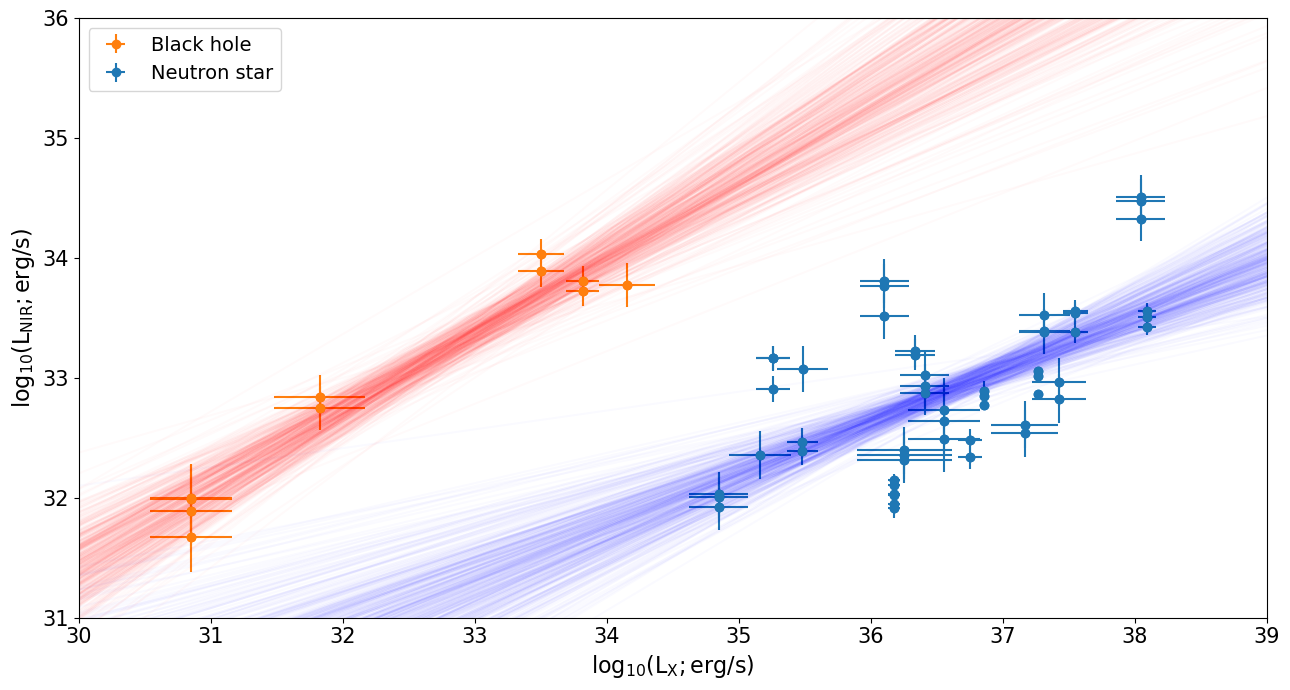

In [23]:
fig, ax = plt.subplots(figsize=(13,7))
# ax = fig.add_subplot(111)
# ax.scatter(xi, eta)
# ax.set_xlabel(r'$\xi$')
# ax.set_ylabel(r'$\eta$')
# ax.set_xlim(-6,6)
# ax.set_ylim(-3,4)
# ax = fig.add_subplot(122)
ax.scatter(x_bh, y_bh, alpha=1, color='C1')
ax.errorbar(x_bh, y_bh, xerr=xsig_bh, yerr=ysig_bh, ls=' ', alpha=1, color='C1', label='Black hole',fmt='o')
ax.scatter(x_ns, y_ns, alpha=1)
ax.errorbar(x_ns, y_ns, xerr=xsig_ns, yerr=ysig_ns, ls=' ', alpha=1, label='Neutron star', fmt='o')

for i in range(0, len(lm_ns.chain), 25):
    xs = np.arange(30,41)
    ys = lm_ns.chain[i]['alpha'] + xs * lm_ns.chain[i]['beta']
    ax.plot(xs, ys, color='b', alpha=0.02)
for i in range(0, len(lm_bh.chain), 25):
    xs = np.arange(30,41)
    ys = lm_bh.chain[i]['alpha'] + xs * lm_bh.chain[i]['beta']
    ax.plot(xs, ys, color='r', alpha=0.02)
# ys = alpha + xs * beta
# ax.plot(xs, ys, color='k')

ax.set_xlabel(r'$\mathrm{log_{10}(L_{X}; erg/s)}$', fontsize=16)
ax.set_ylabel(r'$\mathrm{log_{10}(L_{NIR}; erg/s)}$', fontsize=16)
ax.set_xlim(30, 39)
ax.set_ylim(31, 36)
ax.tick_params(axis='both', labelsize=15)

# ax.plot([-6,6,6,-6,-6], [-3,-3,4,4,-3], color='k')
fig.tight_layout()




tbl2 = pd.read_csv('preprocessed_data_avg_30error.csv')
tbl2['log_L_X_avgerr'] = (tbl2['log_L_X_errlow'] + tbl2['log_L_X_errup'])/2
tbl2['log_L_NIR_avgerr'] = (tbl2['log_L_NIR_errlow'] + tbl2['log_L_NIR_errup'])/2
# tbl = tbl.drop(tbl[tbl['Source'] == 'RX_J1735.3-3540'].index)
tbl2 = tbl2.drop(tbl2[tbl2['Source'] == 'MAXI_J0556-332'].index)

states2 = pd.read_csv('FSRED Mags - total_source_list.csv')
# BH/NS
nss2 = states2[((states2['NS/BH']=='NS') | (states2['NS/BH']=='NS ')| (states2['NS/BH']=='NS (UC)')) &  (states2['Hard/soft state ']=='quiescence')]['Source'].to_list()
nss2.append('XSS_J12270-4859')

NS_tbl2 = tbl2[tbl2['Source'].isin(nss2)]
valid_ns2 = ~(np.isnan(NS_tbl2['L_X']) | np.isnan(NS_tbl2['L_NIR']))


x_ns2 = list(NS_tbl2['log_L_X'][valid_ns2])
y_ns2 = list(NS_tbl2['log_L_NIR'][valid_ns2])
xsig_ns2 = list(NS_tbl2['log_L_X_avgerr'][valid_ns2])
ysig_ns2 = list(NS_tbl2['log_L_NIR_avgerr'][valid_ns2])
# ax.scatter(x_ns2, y_ns2, alpha=1, color='Grey')
# ax.errorbar(x_ns2, y_ns2, xerr=xsig_ns2, yerr=ysig_ns2, ls=' ', alpha=1, color='Grey', label='Neutron star (quiescent)', fmt='o')
ax.legend(fontsize=14)


In [24]:
print(np.mean(lm_bh.chain['beta']), np.std(lm_bh.chain['beta']))
print(np.mean(lm_bh.chain['alpha']), np.std(lm_bh.chain['alpha']))
print('ns')
print(np.mean(lm_ns.chain['beta']), np.std(lm_ns.chain['beta']))
print(np.mean(lm_ns.chain['alpha']), np.std(lm_ns.chain['alpha']))

0.6410365900448876 0.08931992660129154
12.21150142520955 2.9256434396356665
ns
0.4418455497024718 0.08410571172280541
16.727523787440497 3.078757147695643


In [25]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y, s=0.1)
#     ax.set_ylim(0,80)
    
    factor = np.max(np.abs(x))/np.max(np.abs(y))
    print(factor)

    # now determine nice limits by hand:
    binwidth = 0.25
#     xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
#     lim = (int(xymax/binwidth) + 1) * binwidth
    xlim = int(np.max(np.abs(x)/binwidth) + 1) * binwidth
    bins = np.arange(0, 1.2 + binwidth, binwidth*factor)
    ax_histx.hist(x, bins=bins)
    
    ylim = int(np.max(np.abs(y)/binwidth) + 1) * binwidth
    bins = np.arange(-ylim, ylim + binwidth, binwidth)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

0.03991130433807515
0.025744867609958567


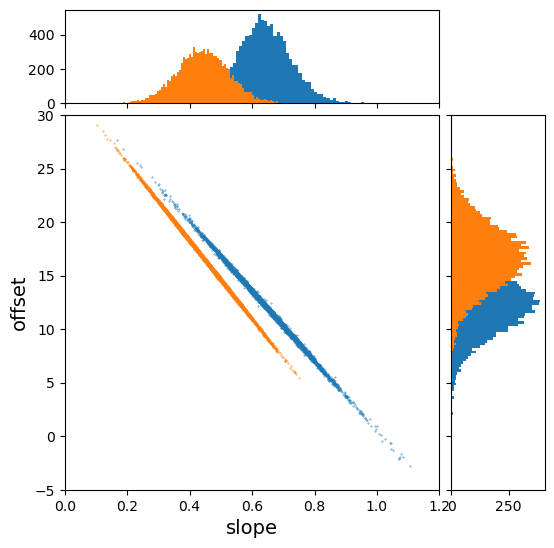

In [26]:
# Start with a square Figure.
fig = plt.figure(figsize=(6, 6))
# Add a gridspec with two rows and two columns and a ratio of 1 to 4 between
# the size of the marginal axes and the main axes in both directions.
# Also adjust the subplot parameters for a square plot.
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
# Create the Axes.
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
# Draw the scatter plot and marginals.
scatter_hist(lm_bh.chain['beta'], lm_bh.chain['alpha'], ax, ax_histx, ax_histy)
scatter_hist(lm_ns.chain['beta'], lm_ns.chain['alpha'], ax, ax_histx, ax_histy)
ax.set_xlabel('slope', fontsize=14)
ax.set_ylabel('offset', fontsize=14)
ax.set_ylim(-5, 30)
ax.set_xlim(0, 1.2)
plt.show()

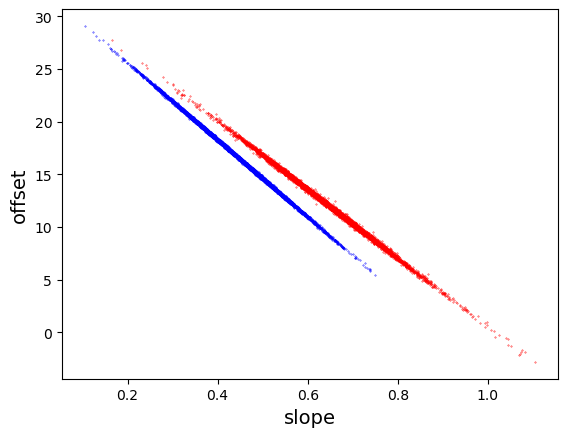

In [27]:
plt.scatter(lm_bh.chain['beta'], lm_bh.chain['alpha'], s=0.1, color='r')
plt.scatter(lm_ns.chain['beta'], lm_ns.chain['alpha'], s=0.1, color='b')
plt.xlabel('slope', fontsize=14)
plt.ylabel('offset', fontsize=14)
plt.show()

In [28]:
# Calculate amount of NIR luminosties 
# print(len(set(bhs)))
# print(len(set(nss)))
# tbl = pd.read_csv('preprocessed_data_avg_30error.csv')
# valid = ~(np.isnan(tbl['L_NIR']))

# print(len(set(NS_tbl['Source'][valid])))
# print(len(set(BH_tbl['Source'][valid])))

In [29]:
# calculate amount of NIR upper limits
# tbl = pd.read_csv('preprocessed_data_avg_30error.csv')
# valid = ~(np.isnan(tbl['L_NIR_upplim']))

# print(len(set(NS_tbl['Source'][valid])))
# print(len(set(BH_tbl['Source'][valid])))